## For Colabs

In [3]:
from getpass import getpass
import os

user = "OliverJBoom"
password = getpass('github password')
os.environ['GITHUB_AUTH'] = user + ':' + password

!rm -rf "/content/acse-9-independent-research-project-OliverJBoom"
!git clone https://$GITHUB_AUTH@github.com/msc-acse/acse-9-independent-research-project-OliverJBoom.git

github password··········
Cloning into 'acse-9-independent-research-project-OliverJBoom'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 452 (delta 0), reused 3 (delta 0), pack-reused 446
Receiving objects: 100% (452/452), 5.92 MiB | 38.60 MiB/s, done.
Resolving deltas: 100% (238/238), done.


In [4]:
from google.colab import drive
drive.mount("/content/gdrive/", force_remount=True)
path = "/content/gdrive/My Drive/Chai/Data"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [5]:
import os
os.chdir("acse-9-independent-research-project-OliverJBoom/Src")
os.listdir()
os.getcwd()
#  os.chdir("/content") 

'/content/acse-9-independent-research-project-OliverJBoom/Src'

## Loading Packages

In [6]:
from deeplearning import *
from models import *
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import shift
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from preprocessing import *
from statistics import median
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from utils import *
import warnings

warnings.filterwarnings("ignore")

set_seed(42)

True

### Insuring that training is done on GPU if available

In [7]:
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


## Loading Data

In [0]:
path = "Data/Commodity_Data/"
universe_dict = universe_select(path, "Cu")

## Preprocessing

In [9]:
# Renaming the columns to price
universe_dict = price_rename(universe_dict)

# Cleaning the dataset of any erroneous datapoints
universe_dict = clean_dict_gen(universe_dict)

# Making sure that all the points in the window have consistent length
universe_dict = truncate_window_length(universe_dict)

# Lg Returns Only
# df_full = generate_dataset(universe_dict, lg_returns_only=True, price_only=False)

# Price Only
df_full = generate_dataset(universe_dict, lg_returns_only=False, price_only=True)

PCA_used = False

Included Instrument:
cu_shfe
cu_lme
cu_comex_p
cu_comex_s
peso
sol
bdi
ted
vix
skew
gsci


The target column represents the log returns at one forecast length out in the future for the instrument of interest (aluminium or copper prices on the London Metals Exchange). 

To normalise the independent variables, the 1 day log returns between closing prices have been used.

In [0]:
# Visualise the plots
# visualise_universe(universe_dict)
# df_full = df_full[["price_cu_lme"]]
# df_full = df_full[["cu_lme"]]

In [10]:
df_full.head(15)
# df_full.tail(5)

,price_cu_shfe,price_cu_lme,price_cu_comex_p,price_cu_comex_s,price_peso,price_sol,price_bdi,price_ted,price_vix,price_skew,price_gsci
date,,,,,,,,,,,
2006-09-13,69540.0,7484.5,3.3925,15748.0,537.35,3.2530,4129.0,4.901,11.18,120.44,438.38855
2006-09-14,71350.0,7439.0,3.3820,14180.0,537.73,3.2475,4207.0,4.926,11.55,119.47,433.72522
2006-09-15,69400.0,7281.0,3.3165,14775.0,537.10,3.2480,4258.0,4.939,11.76,135.25,431.58291
2006-09-18,69830.0,7459.0,3.4180,15263.0,537.10,3.2450,4279.0,4.949,11.78,127.35,434.97293
2006-09-19,71470.0,7516.0,3.3755,17523.0,537.10,3.2450,4275.0,4.948,11.98,125.03,426.51240
2006-09-20,69610.0,7474.0,3.3700,18091.0,537.80,3.2450,4244.0,4.937,11.39,122.71,418.32234
2006-09-21,70170.0,7602.0,3.4220,19546.0,539.70,3.2480,4200.0,4.921,12.25,119.68,423.56908
2006-09-22,71170.0,7601.0,3.4395,20627.0,538.50,3.2470,4136.0,4.924,12.59,118.86,418.01647
2006-09-25,71130.0,7560.0,3.4475,20978.0,539.30,3.2490,4069.0,4.907,12.12,120.75,418.93144


In [0]:
# Forecast length
forecast_length = 5

# Data scaling
scaler_data_X = MinMaxScaler()
scaler_data_y = MinMaxScaler()

df_target = df_full[["price_cu_lme"]]

data_X = scaler_data_X.fit_transform(df_full)[:-forecast_length, :]
# Need to have an independent scaler for inverse_transforming later
data_y = scaler_data_y.fit_transform(df_target)

# Offset target one forecast length
data_y = shift(data_y.ravel(), -forecast_length)[:-forecast_length]
# Check shape assert(data_X.shape[:, 0]== data_y.shape[0])

### PCA

In [112]:
# Reducing the dataset to containing a threshold amount of variance
n_dim = dimension_selector(data_X, thresh=0.95)
data_X = dimension_reduce(data_X, n_dim)

PCA_used = True

Number of dimensions: 6
Explained Variance: [0.49030338 0.23270694 0.1439148  0.04789975 0.02769706 0.0219951 ] 
Explained Variance Sum: 0.9645170286882985


### Chunking Series into Windows

In [0]:
# The input size of each time series window
series_length = 250
  
data_X, data_y = slice_series(data_X, data_y, series_length)

### Class for LSTM deep learning

In [0]:
# class DeepLearning():
#     """Class to perform training and validation for a given model
#     :param
#     model: nn.Module the model to be trained
#     df_X
#     df_y
#     n_epochs,
#     optimiser, 
#     window_size,
#     loss_function
#     device
#     seed=42
#     debug
#     """
#     def __init__(self, model, data_X, data_y,
#                  n_epochs,
#                  optimiser, 
#                  window_size,
#                  loss_function=torch.nn.MSELoss(size_average=False),
#                  device="cpu", 
#                  seed=42,
#                  debug = True, 
#                  disp_freq=20,
#                  fig_disp_freq=50, 
#                  early_stop=True,
#                  patience=50,
#                  tol=0):
        
        
#         # The neural network architecture
#         self.model = model
        
#         # The optimiser for gradient descent
#         self.optimiser = optimiser
        
#         # Dataframe of training values
#         self.data_X = data_X
        
#         # Dataframe of target values
#         self.data_y = data_y
        
#         # The number of epochs
#         self.n_epochs = n_epochs
        
#         #self.optimiser = optimiser
#         self.loss_function = loss_function
        
#         # Whether to run on cpu or gpu
#         self.device = device
        
#         # The random seed to set
#         self.seed = seed
        
#         # To activate debug mode
#         self.debug = debug
        
#         # For training/val logs
#         self.logs = {}
        
#         # The array of predicted lists for each batch for training
#         self.train_predictions = None
        
#         # The array of predicted lists for each batch for validation
#         self.val_predictions = None
        
#         # The array of predicted lists for each batch for validation
#         self.test_predictions = None
        
#         # The data
#         self.X_train = None
#         self.X_val = None
#         self.X_test = None
        
#         # The targets
#         self.y_train = None
#         self.y_val = None
#         self.y_test = None
        
#         # Val data loader
#         self.val_loader = None
        
#         # Test data loader
#         self.test_loader = None
        
#         # The length of the time series window
#         self.window_size = window_size
        
#         # How frequently the loss is printed
#         self.disp_freq = disp_freq
        
#         # How frequently a figure is plotted
#         self.fig_disp_freq = fig_disp_freq
        
#         # Storing the best model
#         self.best_model = self.model
        
#         # Dummy variable for inspecting quantities
#         self.inspect = None
        
#         # For running dataloaders on CUDA
#         self.pin_memory = False
        
#         self.early_stop = early_stop
        
#         if self.early_stop: 
#           self.early = early_stopping(patience=patience, rel_tol=tol)
        
        
#     def train_val_test(self):
#         """Splits the dataframes in to a training, validation
#         and test set and creates torch tensors from the underlying
#         numpy arrays"""
#         # Splitting the sets into train, test and validation
#         self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.data_X, self.data_y, test_size=0.2, shuffle=False)
        
#         self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(self.X_train, self.y_train, test_size=0.25, shuffle=False)

#         if self.debug:
#             print("Train Length: \t\t%i\nValidation Length: \t%i\nTest Length:\t\t%i" 
#                   % (len(X_train), len(X_val), len(X_test)))
        
#         # Tensor of training data
#         self.X_train = torch.from_numpy(self.X_train).float()
#         self.y_train = torch.from_numpy(self.y_train).float()

#         # Tensor of training labels
#         self.X_val = torch.from_numpy(self.X_val).float()
#         self.y_val = torch.from_numpy(self.y_val).float()

#         #  Tensor of test data
#         self.X_test = torch.from_numpy(self.X_test).float()
#         self.y_test = torch.from_numpy(self.y_test).float()

#         # Size Check
#         if self.debug:
#             print("\nInitial Size Check:")
#             self.size_check()
    
    
#     def size_check(self):
#         """Checks the size of the datasets"""
#         if self.debug:
#             print("\nX Train Shape:\t\t", self.X_train.size())
#             print("X Val Shape:\t\t", self.X_val.size())
#             print("X Test Shape:\t\t", self.X_test.size())

#             print("\ny Train Shape:\t\t", self.y_train.size())
#             print("y Val Shape:\t\t", self.y_val.size())
#             print("y Test Shape:\t\t", self.y_test.size())

        
    
#     def create_data_loaders(self):
#         """Forms iterators to pipeline in the data"""
            
#         # Create tensor datasets
#         train_dataset = TensorDataset(self.X_train, self.y_train)
#         val_dataset = TensorDataset(self.X_val, self.y_val)
#         test_dataset = TensorDataset(self.X_test, self.y_test)
        
#         if self.device =='cuda': self.pin_memory=True
          
#         # Data loaders
#         self.train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False, num_workers=8,  pin_memory=self.pin_memory)
#         self.val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=8,  pin_memory=self.pin_memory)
#         self.test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=8,  pin_memory=self.pin_memory)
    
    
#     def train(self, train_loader):
#         """Performs a single training cycle and returns the
#         mean squared error loss for the training dataset"""
#         # Sets the model to train mode
#         self.model.train()
        
#         train_loss = 0.
        
#         # List of each batch predictions
#         pred_list = []
        
#         # The data loader creates batches of data to train
#         for i_batch, (X_train_batch, y_train_batch) in enumerate(train_loader):
            
#             #print('Batch : ', i_batch)
            
#             # Sending the data to GPU if available
#             X_train_batch = X_train_batch.to(self.device)
#             y_train_batch = y_train_batch.to(self.device)
            
#             # Zeros the gradients
#             self.optimiser.zero_grad()

#             # Need to set seed here to make deterministic
#             set_seed(42)
        
#             # Perform forward pass
#             y_pred = self.model(X_train_batch)
            
#             # Calculate loss for the batch
#             loss = self.loss_function(y_pred, y_train_batch)   

#             # Perform backward pass
#             loss.backward()   

#             # Adding the predictions for this batch to prediction list
#             pred_list.append(y_pred)
            
#             # Calculate the training loss
#             train_loss += (loss * X_train_batch.size()[0]).detach().cpu().numpy()

#             # Update Parameters
#             self.optimiser.step()               
        
#         # Converting an array of batches of predictions to a list of predictions
#         self.train_predictions = [single_pred for batch in pred_list for single_pred in batch.detach().cpu().numpy()]
        
#         return train_loss/len(train_loader.dataset.tensors[0])
    
    
#     def validate(self, val_loader):
#         """Evaluates the performance of the network
#         on unseen validation data"""
#         # Set the model to evaluate mode
#         self.model.eval()
        
#         val_loss = 0.
        
#         # List of each batch predictions
#         val_pred_list = []
        
#         # The data loader creates batches of data to validate
#         for X_val_batch, y_val_batch in val_loader:
            
#             # Ensures that the gradients are not updated
#             with torch.no_grad():
                
#                 # Sending the data to GPU if available
#                 X_val_batch = X_val_batch.to(self.device)
#                 y_val_batch = y_val_batch.to(self.device)

#                 # Perform forward pass
#                 y_pred = self.model(X_val_batch)

#                 # Calculate loss for the batch
#                 loss = self.loss_function(y_pred, y_val_batch) 
                
#                 # Adding the predictions for this batch to prediction list
#                 val_pred_list.append(y_pred)
                
#                 # Calculate the validation loss
#                 val_loss += (loss * X_val_batch.size()[0]).detach().cpu().numpy()
        
#         # Converting an array of batches of predictions to a list of predictions
#         self.val_predictions = [single_pred for batch in val_pred_list for single_pred in batch.detach().cpu().numpy()]
        
#         return val_loss/len(val_loader.dataset.tensors[0])
    
    
#     def evaluate(self, model, test_loader):
#         """Evaluates the performance of the network on unseen test data"""
#         # Set the model to evaluate mode
#         model.eval()

#         test_loss = 0.

#         # List of each batch predictions
#         test_pred_list = []

#         # The data loader creates batches of data to validate
#         for X_test_batch, y_test_batch in test_loader:

#             # Ensures that the gradients are not updated
#             with torch.no_grad():

#                 # Sending the data to GPU if available
#                 X_test_batch = X_test_batch.to(self.device)
#                 y_test_batch = y_test_batch.to(self.device)

#                 # Perform forward pass
#                 y_pred = model(X_test_batch)

#                 # Calculate loss for the batch
#                 loss = self.loss_function(y_pred, y_test_batch) 

#                 # Adding the predictions for this batch to prediction list
#                 test_pred_list.append(y_pred)

#                 # Calculate the validation loss
#                 test_loss += (loss * X_test_batch.size()[0]).detach().cpu().numpy()

#         # Converting an array of batches of predictions to a list of predictions
#         self.test_predictions = [single_pred for batch in test_pred_list for single_pred in batch.detach().cpu().numpy()]

#         return test_loss/len(test_loader.dataset.tensors[0])
      
    
#     def live_pred_plot(self):
#         fig, ax = plt.subplots(1, 3, figsize= (20, 5))
  
#         ax[0].plot(self.train_predictions, label="Predicted")
#         ax[0].plot(self.y_train.numpy(), label="Observed")
#         ax[0].legend()
        
#         ax[1].plot(self.val_predictions, label="Val Predicted")
#         ax[1].plot(self.y_val.numpy(), label="Val Observed")
#         ax[1].legend()
        
#         ax[2].set_title("Loss Plots")
#         ax[2].plot(self.logs['Training Loss'], label="Training Loss")
#         ax[2].plot(self.logs['Validation Loss'], label="Validation Loss")
#         ax[2].legend()
#         ax[2].set_ylim((0, median(self.logs['Validation Loss'])))
        
#         plt.show()
    
#     def training_wrapper(self):
        
#         # start timer
#         start_time = time.time()

#         # set seed
#         set_seed(int(self.seed))
        
#         # Create data loaders
#         learning.create_data_loaders()
        
#         train_log = []
#         val_log = []
        
#         # The best validation score tracker
#         self.best_val_score = np.inf
        
#         # Begin training
#         for epoch in range(self.n_epochs):
            
#             live_logs = {}
            
#             train_loss = self.train(self.train_loader) 
#             val_loss = self.validate(self.val_loader) 
            
#             # Saving the best model
#             if val_loss <= self.best_val_score:
#                 self.best_model = self.model
#                 self.best_val_score = val_loss.item()
            
#             train_log.append(train_loss.item())
#             val_log.append(val_loss.item())
#             self.logs["Training Loss"] = train_log
#             self.logs["Validation Loss"] = val_log
#             self.logs["Time"] = time.time() - start_time
            
#             # Checking stopping criteria
#             if self.early_stop: 
#                 self.early(val_loss.item())
#                 if self.early.stop:
#                     print("Early Stopping")
#                     break
                  
#             if (epoch % self.disp_freq == 0): 
#                 print("Epoch: %i Train MSE: %.5f Val MSE: %.5f  Time: %.3f" % (epoch, train_loss.item(),
#                                                           val_loss.item(), (time.time() - start_time)))
                
#             if (epoch % self.fig_disp_freq == 0):
#                 self.live_pred_plot()

### Hyperparameters

In [0]:
# Hyperparameters
learning_rate = 1e-2
momentum = 0.5
weight_decay = 0

# Batch Parameters
batch_size = 32
test_batch_size = 1000
# series_length = 100

n_epochs = 5

# Model Parameters
num_features = data_X.shape[2]
hidden_dim = 128
num_layers = 2
output_dim = 1

### Initialising the model

In [0]:
model_lstm = LSTM(num_features=num_features, 
             hidden_dim=hidden_dim, 
             series_length = series_length,
             batch_size=batch_size,
             output_dim=output_dim, 
             num_layers=num_layers, 
             device=device)

model_lstm.to(device)

print("num_features %i \nhidden_dim %i\nseries_length %i \nbatch_size %i\noutput_dim %i \nnum_layers %i"
      % (num_features, hidden_dim, series_length, batch_size,output_dim, num_layers))

print('data_X ', data_X.shape, '\ndata_y', data_y.shape)

num_features 6 
hidden_dim 128
series_length 250 
batch_size 32
output_dim 1 
num_layers 2
data_X  (3078, 250, 6) 
data_y (3078,)


In [98]:
# Loading trained model
model = torch.load("/content/gdrive/My Drive/Chai/Models/LSTM_0_040.pth")
# model.dropout = 0.2
model.to(device)

LSTM(
  (lstm): LSTM(6, 128, num_layers=2, dropout=0.1)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (act): ReLU()
  (out): Linear(in_features=128, out_features=1, bias=True)
)

inf
Count: 0
Epoch: 0 Train MSE: 0.06317 Val MSE: 0.17178  Time: 14.366


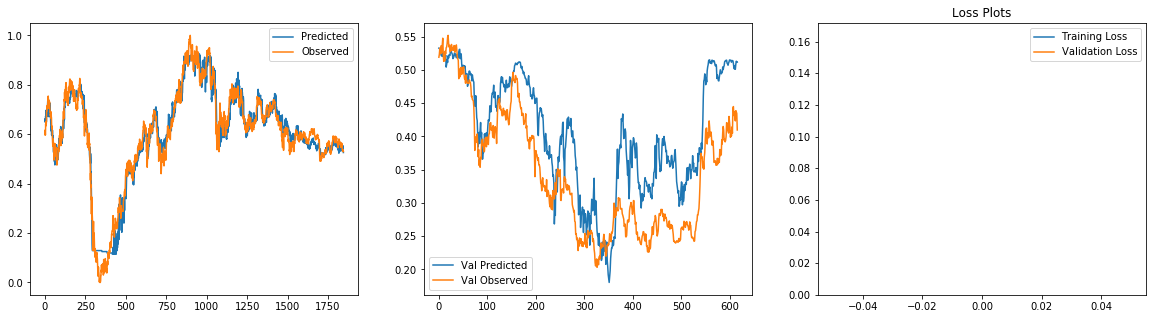

0.17178268261350593
Count: 1
Epoch: 1 Train MSE: 0.08559 Val MSE: 0.75770  Time: 25.027


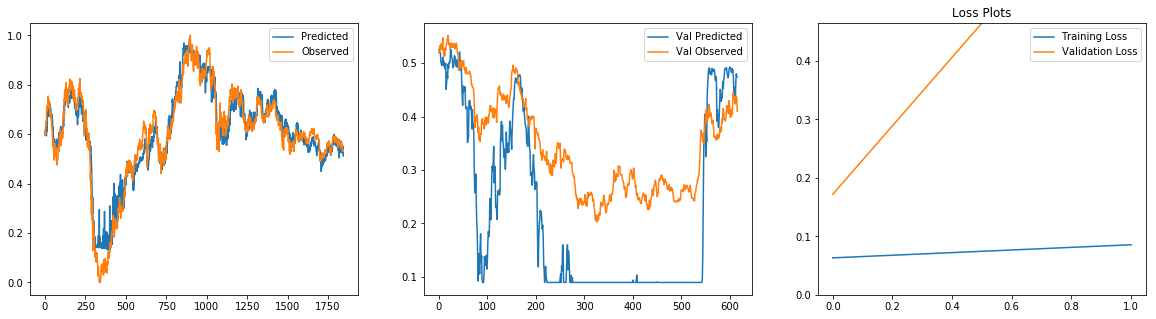

0.17178268261350593
Count: 2
Epoch: 2 Train MSE: 0.11107 Val MSE: 0.18517  Time: 35.551


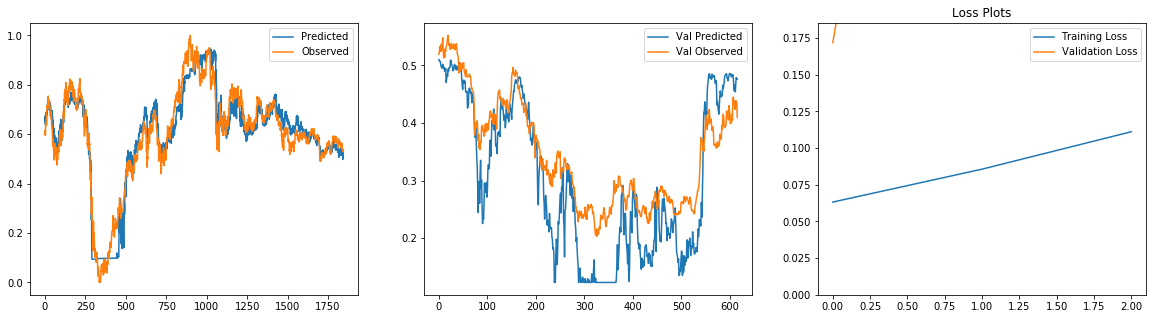

0.17178268261350593
Count: 3
Epoch: 3 Train MSE: 0.07256 Val MSE: 0.51390  Time: 46.083


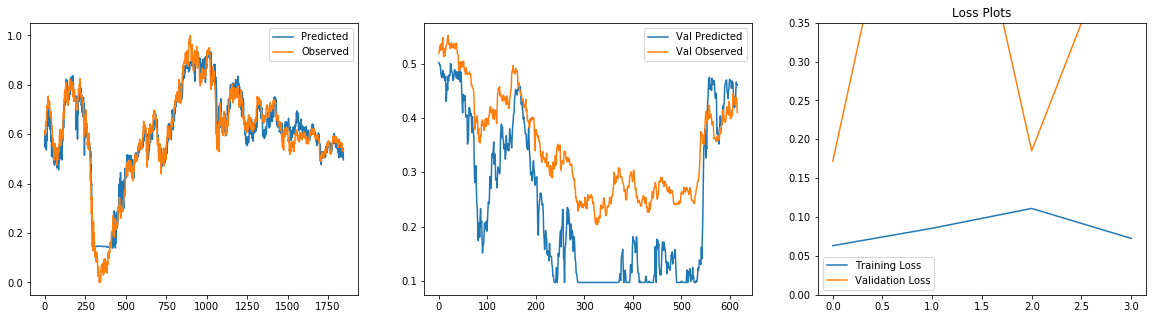

0.17178268261350593
Count: 4
Epoch: 4 Train MSE: 0.07170 Val MSE: 0.23983  Time: 56.658


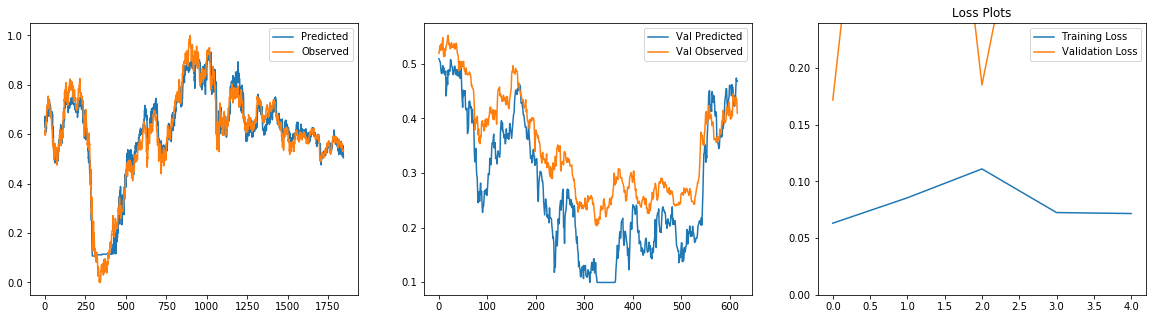

0.17178268261350593
Count: 5
Epoch: 5 Train MSE: 0.06589 Val MSE: 0.17413  Time: 71.230


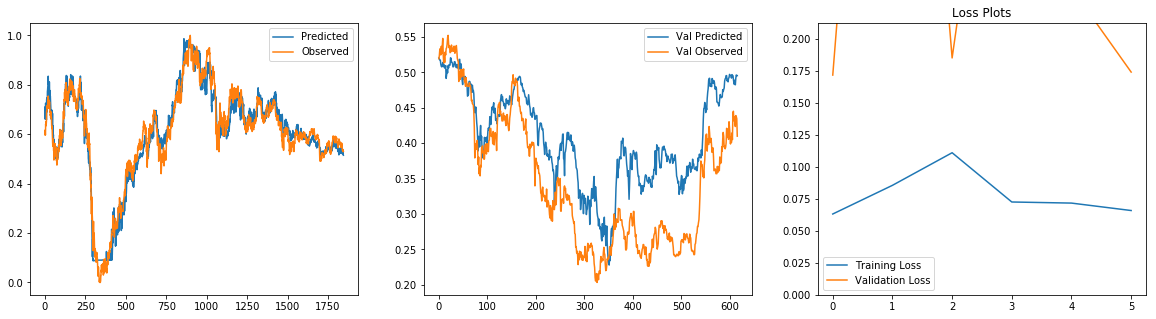

KeyboardInterrupt: ignored

In [101]:
optimiser = torch.optim.Adam(model.parameters(), learning_rate)
# optimizer = optim.RMSprop(model_lstm.parameters(), lr=learning_rate, weight_decay=0.0)

"""Do I need to declare a data explicitly in the dataset"""
learning = DeepLearning(model=model, 
                        data_X=data_X, 
                        data_y=data_y, 
                        n_epochs=2000,
                        optimiser=optimiser,
                        window_size=series_length,
                        debug=False, 
                        disp_freq=1,
                        fig_disp_freq=1, 
                        device=device,
                        patience=15)

# Splitting the data into the train, validation and test sets
learning.train_val_test()
learning.create_data_loaders()
learning.training_wrapper()

In [100]:
val_score = learning.evaluate(learning.best_model, learning.val_loader)
print(val_score)

0.3735263411487852


In [0]:
import pickle

pickle.dump(learning, open("/content/gdrive/My Drive/Chai/Models/Pickles" + "learning_object", 'wb'))

In [0]:
learning_load = pickle.load(open("/content/gdrive/My Drive/Chai/Models/Pickles" + "learning_object", 'rb'))

In [0]:
model_save(model_lstm, 
           path="/content/gdrive/My Drive/Chai/Models/Pths",
           name="LSTM_Full", 
           val_score=learning.best_val_score)

# mod = model_load(path="Models/Pths",
#            model_name="LSTM_5_854")

Saving model: /content/gdrive/My Drive/Chai/Models/LSTM_Full_0_046.pth


### Plotting

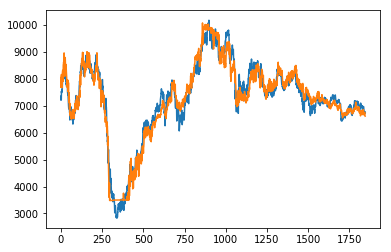

In [143]:
# Rescaling Example

scaler_data_y.inverse_transform(np.array(learning_load.train_predictions).reshape(-1, 1))
plt.plot(scaler_data_y.inverse_transform(learning_load.y_train.numpy().reshape(-1, 1)))
plt.plot(scaler_data_y.inverse_transform(np.array(learning_load.train_predictions).reshape(-1, 1)))
plt.show()

In [0]:
predicted_train = learning.train_predictions
observed_train = learning.y_train.numpy()

learning.model = learning.best_model
learning.validate(learning.val_loader)
predicted_val = learning.val_predictions
observed_val = learning.y_val.numpy()

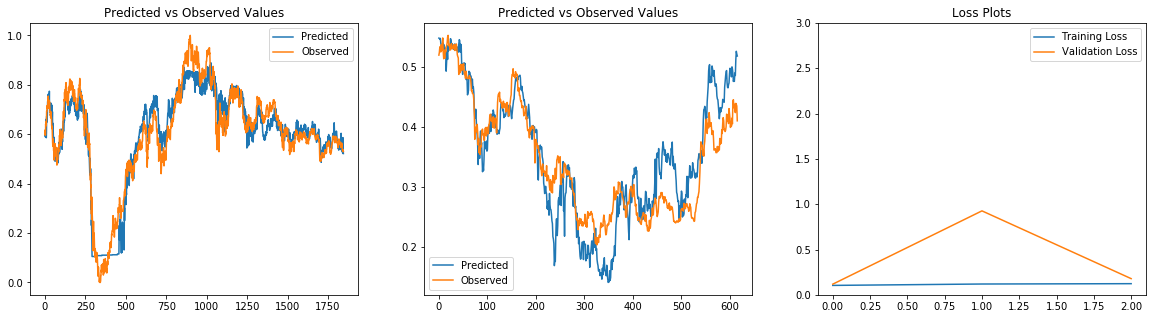

In [0]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

ax[0].set_title("Predicted vs Observed Values")
ax[0].plot(predicted_train, label="Predicted")
ax[0].plot(observed_train, label="Observed")
ax[0].legend()

ax[1].set_title("Predicted vs Observed Values")
ax[1].plot(predicted_val, label="Predicted")
ax[1].plot(observed_val, label="Observed")
ax[1].legend()
           
ax[2].set_title("Loss Plots")
ax[2].plot(learning.logs['Training Loss'], label="Training Loss")
ax[2].plot(learning.logs['Validation Loss'], label="Validation Loss")
ax[2].legend()
ax[2].set_ylim((0, 3))

epoch_reached = str(len(learning.logs['Training Loss']))
path="/content/gdrive/My Drive/Chai/Models/"

plt.savefig(path + str("LSTM_Val_" + str(val_score)[:5].replace(".", "_") + "_Epoch_" + epoch_reached + ".png"))
plt.show()

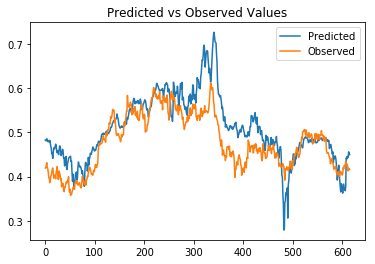

In [0]:
plt.title("Predicted vs Observed Values")
plt.plot(learning.test_predictions, label="Predicted")
plt.plot(learning.y_test.numpy(), label="Observed")
plt.legend()

In [0]:
# The minimum validation loss
val_loss = min(learning.logs['Validation Loss'])
best_model_epoch = learning.logs['Validation Loss'].index(val_loss)
train_loss = learning.logs['Training Loss'][best_model_epoch]
test_loss = learning.evaluate(learning.best_model, learning.test_loader)

In [0]:
num_epoch = 250
train_time = learning.logs["Time"]
full_save(learning.best_model, 
          "Full_Run",
          optimiser,
          num_epoch, 
          learning_rate, 
          momentum,
          weight_decay, 
          PCA_used, 
          data_X,
          train_loss,
          val_loss, 
          test_loss,
          train_time, 
          hidden_dim,
          path="/content/gdrive/My Drive/Chai/Models/") 

Saving model: /content/gdrive/My Drive/Chai/Models/LSTM_0_040.pth


True

# Results

In [0]:
mse, mae, mde = evaluate(learning.test_predictions, learning.y_test.numpy())
print(mse, mae, mde)

0.0026131007 0.039629836 0.45454545454545453


## Persistance

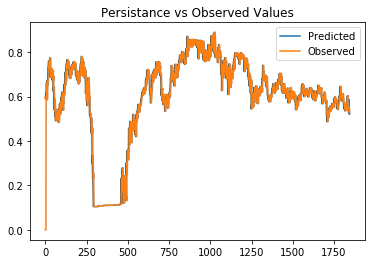

In [0]:
plt.title("Persistance vs Observed Values")
plt.plot(learning.train_predictions, label="Predicted")
plt.plot(shift(learning.train_predictions, 5), label="Observed")
plt.legend()

In [0]:
df = df_full[["target"]]
# Taking t-1 to be the value for t
df["persistance"] = df.shift(1)
df.dropna(inplace=True)
# Calculating metrics for these columns
MSE, MAE, MDE = evaluate(df, "target", "persistance")

In [0]:
print(df[:5])
print(df[-5:])

              target  persistance
date                             
2006-09-14  0.021675    -0.001404
2006-09-15  0.043012     0.021675
2006-09-18  0.013450     0.043012
2006-09-19  0.025225     0.013450
2006-09-20  0.024843     0.025225
              target  persistance
date                             
2019-06-24 -0.000589     0.004104
2019-06-25 -0.026401    -0.000589
2019-06-26 -0.010480    -0.026401
2019-06-27 -0.011358    -0.010480
2019-06-28 -0.015457    -0.011358


In [0]:
# Placing in results dataframe
results = pd.DataFrame(columns={"MSE", "MAE", "MDE"})
results.index.name = 'Name'
results.head()
results.loc["persistance"] = [MSE, MAE, MDE] 
results.head()

,MSE,MAE,MDE
Name,,,
persistance,0.000582,0.017105,0.465585
